In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
# import talib
import pickle
import pystan

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

# Generative models

## Dynamic

In [ ]:
def dynamic_prior(batch_size, fixed_var=None):
    """
    Generates a random draw from the diffusion model prior.
    """
    v = np.random.gamma(2.5, 1/1.5, (batch_size, 4))
    a = np.random.gamma(4.0, 1/3.0, batch_size)
    ndt = np.random.gamma(1.5, 1/5.0, batch_size)
    theta_s = np.random.uniform(0.1, 0.1, (batch_size, 6))
    if fixed_var != None:
        theta_s = np.random.uniform(fixed_var, fixed_var, (batch_size, 6))

    return np.c_[v, a, ndt, theta_s]


@njit
def context_gen(batch_size, n_obs):
    """
    Generates an experimenmt wiht a random sequence of 4 conditions.
    """
    obs_per_condition = int(n_obs / 4)
    context = np.zeros((batch_size, n_obs), dtype=np.int32)
    x = np.repeat([0, 1, 2, 3], obs_per_condition)
    for i in range(batch_size):
        np.random.shuffle(x)
        context[i] = x

    return context


@njit
def diffusion_trial(v, a, ndt, zr=0.5, dt=0.001, s=1.0, max_iter=1e4):
    """
    Simulates a single reaction time from a simple drift-diffusion process.
    """

    n_iter = 0
    x = a * zr
    c = np.sqrt(dt * s)
    
    while x > 0 and x < a:
        
        # DDM equation
        x += v*dt + c * np.random.randn()
        
        n_iter += 1
        
    rt = n_iter * dt
    return rt+ndt if x >= 0 else -(rt+ndt)


@njit
def dynamic_diffusion_process(prior_samples, context, n_obs):
    """
    Performs one run of a dynamic diffusion model process.
    """
    params_t, theta_s = np.split(prior_samples, 2, axis=-1)
    theta_d = np.zeros((n_obs, params_t.shape[0]))
    
    # Draw first param combination from prior
    rt = np.zeros(n_obs)
    
    # Iterate over number of trials
    for t in range(n_obs):
        
        # Run diffusion process
        rt[t] = diffusion_trial(params_t[context[t]], params_t[4], params_t[5])
        
        # Store before transition
        theta_d[t] = params_t
        
        # Transition and ensure non-negative parameters
        params_t = params_t + theta_s * np.random.randn(params_t.shape[0])
        
        # Constraints
        params_t[0] = min(max(params_t[0], 0.0), 8)
        params_t[1] = min(max(params_t[1], 0.0), 8)
        params_t[2] = min(max(params_t[2], 0.0), 8)
        params_t[3] = min(max(params_t[3], 0.0), 8)
        params_t[4] = min(max(params_t[4], 0.001), 6)
        params_t[5] = min(max(params_t[5], 0.001), 4)
        
    return np.atleast_2d(rt).T, theta_d, theta_s


@njit
def dynamic_batch_simulator(prior_samples, context):
    """
    Performs one batch of dynamic diffusion model runs.
    """
    batch_size = prior_samples.shape[0]
    n_obs = context.shape[1]
    rt = np.zeros((batch_size, n_obs, 1))
    theta_d = np.zeros((batch_size, n_obs, 6))
    theta_s = np.zeros((batch_size, 6))
    
    for i in range(batch_size):
        rt[i], theta_d[i], theta_s[i] = dynamic_diffusion_process(prior_samples[i], 
                                                                  context[i],
                                                                  n_obs)
    
    return np.concatenate((rt, np.expand_dims(context, axis=2)), axis=-1), theta_d, theta_s
    

## Static

In [ ]:
@njit
def static_diffusion_process(prior_samples, context, n_obs):
    """
    Performs one run of a static diffusion model process.
    """
    
    params_t, params_stds = np.split(prior_samples, 2, axis=-1)
    
    rt = np.zeros(n_obs)
    
    # Iterate over number of trials
    for t in range(n_obs):
        
        # Run diffusion process
        rt[t] = diffusion_trial(params_t[context[t]], params_t[4], params_t[5])
        
    return np.atleast_2d(rt).T, params_t


@njit
def static_batch_simulator(prior_samples, context):
    """
    Performs one batch of static diffusion model runs.
    """
    batch_size = prior_samples.shape[0]
    n_obs = context.shape[1]
    rt = np.zeros((batch_size, n_obs, 1))
    theta = np.zeros((batch_size, n_obs, 6))

    for i in range(batch_size):
        rt[i], theta[i] = static_diffusion_process(prior_samples[i], 
                                                   context[i],
                                                   n_obs)
    return np.concatenate((rt, np.expand_dims(context, axis=2)), axis=-1), theta

## Stan

In [ ]:
stan_model = """
data {
  int<lower=0> N;                 
  real<lower=0> rt[N];    
  int<lower=0,upper=1> correct[N];
  int<lower=1,upper=4> context[N];
}

parameters {
  real<lower=0> v[4];
  real<lower=0> a; 
  real<lower=0> ndt;
}

model {
  // Priors
  v ~ gamma(2.5, 1.5);
  a ~ gamma(4.0, 3.0);
  ndt ~ gamma(1.5, 5.0);
  
  for (n in 1:N) {
     if (correct[n] == 1) {
        rt[n] ~ wiener(a, ndt, 0.5, v[context[n]]);
     } 
     else {
        rt[n] ~ wiener(a, ndt, 1 - 0.5, -v[context[n]]);
     }
  }
}
"""

In [ ]:
def to_stan(sim_data):
    """
    Convert data from simulator to stan-friendly format.
    """
    rt = sim_data[:, 0]
    context = sim_data[:, 1].astype(np.int32) + 1
    correct = (rt >= 0).astype(np.int32)
    rt = np.abs(rt).astype(np.float32)
    return {'rt': rt, 'correct': correct, 'context': context, 'N': rt.shape[0]}

def loop_stan(data, verbose=True):
    """
    Loop through data and obtain posteriors.
    """
    
    stan_post_samples = []
    for i in range(data.shape[0]):
        data_i = to_stan(data[i])
        ndt_init = data_i['rt'].min() * 0.75
        init = {'ndt': ndt_init}
        fit = sm.sampling(data=data_i, 
                          iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                          control=dict(adapt_delta=0.99, max_treedepth=15))
        samples = fit.extract(permuted=True)
        stan_post_samples.append(samples)
        if verbose:
            print(f'Finished estimating data set {i + 1}...')
    return stan_post_samples

# Simulation

In [ ]:
N_OBS = 800
BATCH_SIZE = 100

In [ ]:
# parallelization for stan
import multiprocessing
multiprocessing.set_start_method("fork")

In [ ]:
# compile stan model
sm = pystan.StanModel(model_code=stan_model)

## No variance (static)

In [ ]:
prior_draws = dynamic_prior(BATCH_SIZE)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d = static_batch_simulator(prior_draws, context)
sim_data.shape

In [ ]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [ ]:
stan_post_samples = loop_stan(sim_data)

In [ ]:
# pickle.dump(
# {
#     'rt': sim_data[:, : , 0], 
#     'context': sim_data[:, : , 1], 
#     'theta_d': theta_d,
#     'stan_post_samples': stan_post_samples
#     }, 
#     open('./simulation_800_noVar.pkl', 'wb+')
# )

## Low variance

In [ ]:
prior_draws = dynamic_prior(BATCH_SIZE, fixed_var=0.001)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
sim_data.shape

In [ ]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [ ]:
stan_post_samples = loop_stan(sim_data)

In [ ]:
# pickle.dump(
# {
#     'rt': sim_data[:, : , 0], 
#     'context': sim_data[:, : , 1], 
#     'theta_d': theta_d,
#     'theta_s': theta_s,
#     'stan_post_samples': stan_post_samples
#     }, 
#     open('./sim_800_lowVar.pkl', 'wb+')
# )

## High variance

In [ ]:
prior_draws = dynamic_prior(BATCH_SIZE, fixed_var=0.1)
context = context_gen(BATCH_SIZE, N_OBS)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
sim_data.shape

In [ ]:
# sanity check
which_param = 0
plt.plot(np.arange(N_OBS), theta_d[0, :, which_param])

In [ ]:
stan_post_samples = loop_stan(sim_data)

In [ ]:
# pickle.dump(
# {
#     'rt': sim_data[:, : , 0], 
#     'context': sim_data[:, : , 1], 
#     'theta_d': theta_d,
#     'theta_s': theta_s,
#     'stan_post_samples': stan_post_samples
#     }, 
#     open('./sim_800_highVar.pkl', 'wb+')
# )

# Amortizers

## Network architecture

In [ ]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic stuff
        preds_dyn = self.dynamic_predictor(rep)
     
        return preds_dyn

## Loss

In [ ]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [ ]:
def static_epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d = static_batch_simulator(prior_draws, context)

            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d = network(net_in)

            # Loss 
            loss_d = nll(theta_d, pred_theta_d)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)


def dynamic_epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar, fixed_var):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size, fixed_var)
            context = context_gen(batch_size, n_obs)
            x_t, theta_d, _= dynamic_batch_simulator(prior_draws, context)

            net_in = tf.concat((sim_data[:, :, :1], sim_data[:, :, 1:]), axis=-1)
            pred_theta_d = network(net_in)

            # Loss dynamic and static
            loss_d = nll(theta_d, pred_theta_d)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

## Training

In [ ]:
N_OBS = 800
BATCH_SIZE = 16
EPOCHS = 50
STEPS_PER_EPOCH = 1000


### No variance (static)

In [ ]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
network = HeteroscedasticNetwork(6)

In [ ]:
for ep in range(1, EPOCHS+1):
    with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
        static_epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar)

In [ ]:
# network.save_weights('checkpoints/static_800')

### Low variance

In [ ]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
network = HeteroscedasticNetwork(6)

In [ ]:
for ep in range(1, EPOCHS+1):
    with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
        dynamic_epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar, 0.001)

In [ ]:
# network.save_weights('checkpoints/lowVar_800')

### High variance

In [ ]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
network = HeteroscedasticNetwork(6)

In [ ]:
for ep in range(1, EPOCHS+1):
    with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
        dynamic_epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar, 0.1)

In [ ]:
# network.save_weights('checkpoints/lowVar_800')

# Evaluation

In [74]:
# load trained network
network_no_var   = HeteroscedasticNetwork(6)
network_low_var  = HeteroscedasticNetwork(6)
network_high_var = HeteroscedasticNetwork(6)
network_no_var.load_weights('checkpoints/static_800')
network_low_var.load_weights('checkpoints/lowVar_800')
network_high_var.load_weights('checkpoints/highVar_800')

In [158]:
def plot_post_sd(stan_post_samples, sim_data, res, types):
    # amortized inference
    bf_post_no_var   = network_no_var(sim_data)
    bf_post_low_var  = network_low_var(sim_data)
    bf_post_high_var = network_high_var(sim_data)

    # get posterior sd's of BayesFlow fits
    bf_post_no_var_sd   = np.array(bf_post_no_var.stddev()).mean(axis=0)
    bf_post_low_var_sd  = np.array(bf_post_low_var.stddev()).mean(axis=0)
    bf_post_high_var_sd = np.array(bf_post_high_var.stddev()).mean(axis=0)

    # get posterior sd's of Stan fits
    stan_sd = np.zeros((100, 6))
    for j in range(100):
        v = stan_post_samples[j]['v']
        a = stan_post_samples[j]['a']
        ndt = stan_post_samples[j]['ndt']

        stan_posterior = np.c_[v, a, ndt]
        stan_sd[j] = stan_posterior.std(axis=0)

    stan_sd = stan_sd.mean(axis=0)

    labels = ['No variance', 'Low variance', 'High variance', "Static Stan"]
    param_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
    colors = ['#D18186', '#7697CA', '#4f8752', "#000000"]
    param_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']
    alpha = 0.8
    linewidth = 3

    time = np.arange(bf_post_no_var_sd.shape[0])
    x_min = int(bf_post_no_var_sd.shape[0] - res)
    f, axarr = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

    for i, ax in enumerate(axarr.flat):
        ax.plot(np.arange(x_min, 800), bf_post_no_var_sd[x_min:, i], color=colors[0], label=labels[0], alpha=alpha, linewidth=linewidth)
        ax.plot(np.arange(x_min, 800), bf_post_low_var_sd[x_min:, i], color=colors[1], label=labels[1], alpha=alpha, linewidth=linewidth)
        ax.plot(np.arange(x_min, 800), bf_post_high_var_sd[x_min:, i], color=colors[2], label=labels[2], alpha=alpha, linewidth=linewidth)

        # ax.plot(np.arange(800), bf_post_no_var_sd[:, i], color=colors[0], label=labels[0], alpha=alpha, linewidth=linewidth)
        # ax.plot(np.arange(800), bf_post_low_var_sd[:, i], color=colors[1], label=labels[1], alpha=alpha, linewidth=linewidth)
        # ax.plot(np.arange(800), bf_post_high_var_sd[:, i], color=colors[2], label=labels[2], alpha=alpha, linewidth=linewidth)

        ax.hlines(y=stan_sd[i], xmin=x_min, xmax=800, color=colors[3], label=labels[3], linestyles="dashed", linewidth=1.5)

        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Posterior standard deviation', fontsize=12)
        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=12)

        if i == 0:  
            ax.legend()
            f.suptitle("Parameter std's over time: {}".format(labels[types]) + " simulated data", fontsize=16)

    f.tight_layout()

### No variance (static)

In [159]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_noVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
stan_post_samples = sim['stan_post_samples']

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_66567/2879062746.py:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


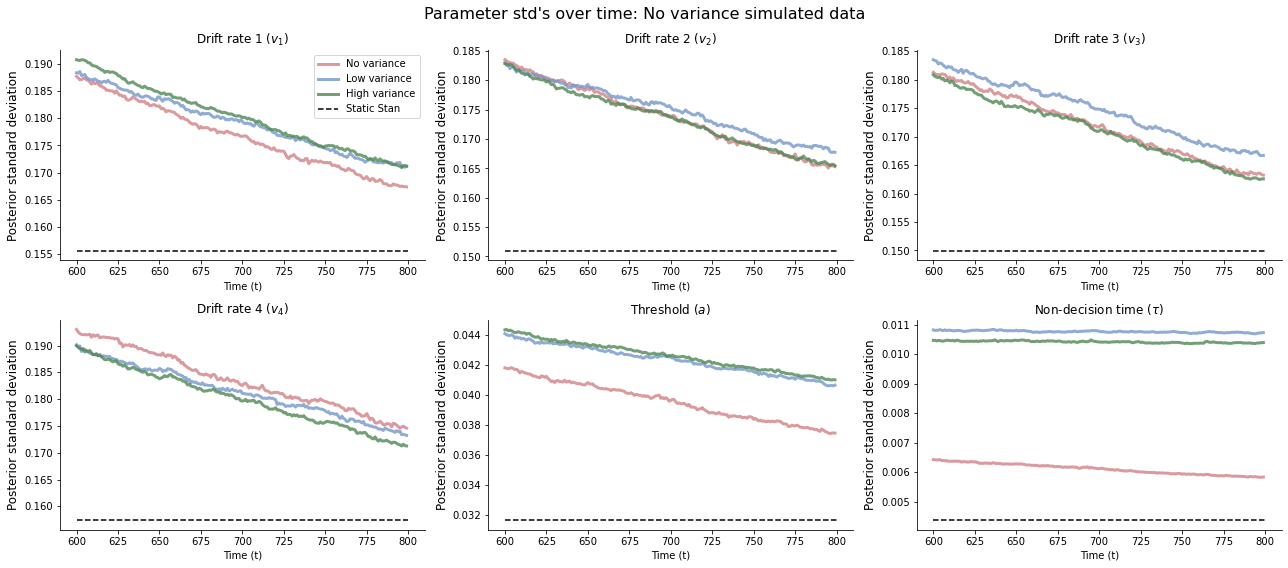

In [163]:
plot_post_sd(stan_post_samples, sim_data, 200, 0)

### Low variance

In [164]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_lowVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
true_theta_d = sim['theta_d']
stan_post_samples = sim['stan_post_samples']

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_66567/2879062746.py:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


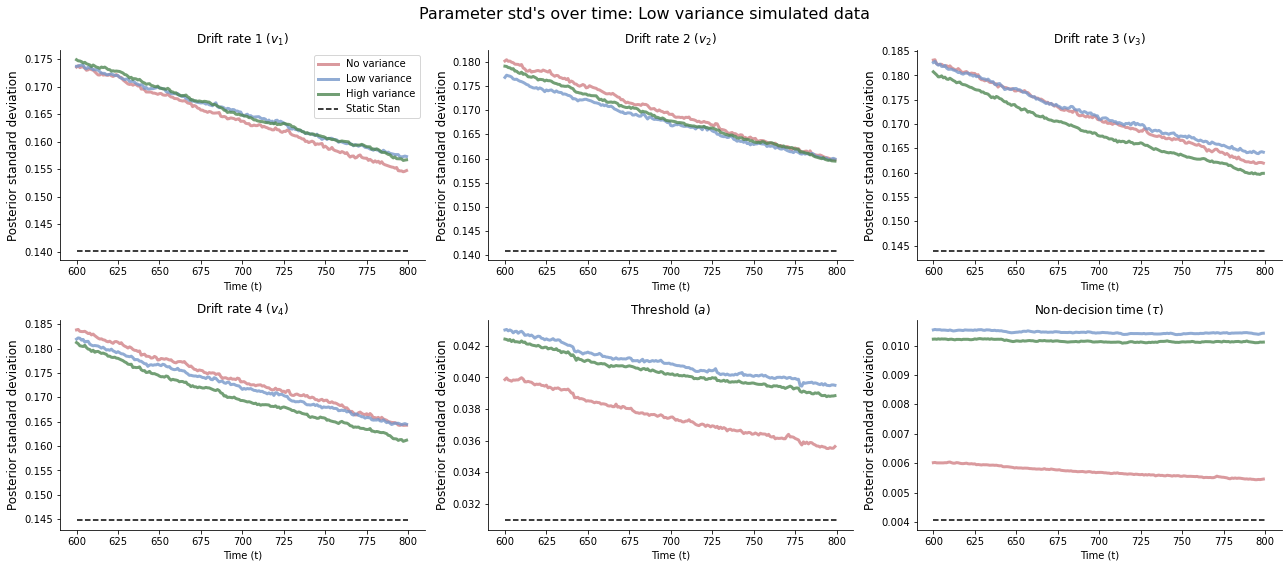

In [165]:
plot_post_sd(stan_post_samples, sim_data, 200, 1)

### High variance

In [166]:
# load simulated data and stan fits
sim = pd.read_pickle('./sim_800_highVar.pkl')
rt = sim['rt']
context = to_categorical(sim['context'])
sim_data = np.concatenate((rt[:, :, np.newaxis], context), axis=-1)
true_theta_d = sim['theta_d']
stan_post_samples = sim['stan_post_samples']

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_66567/2879062746.py:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


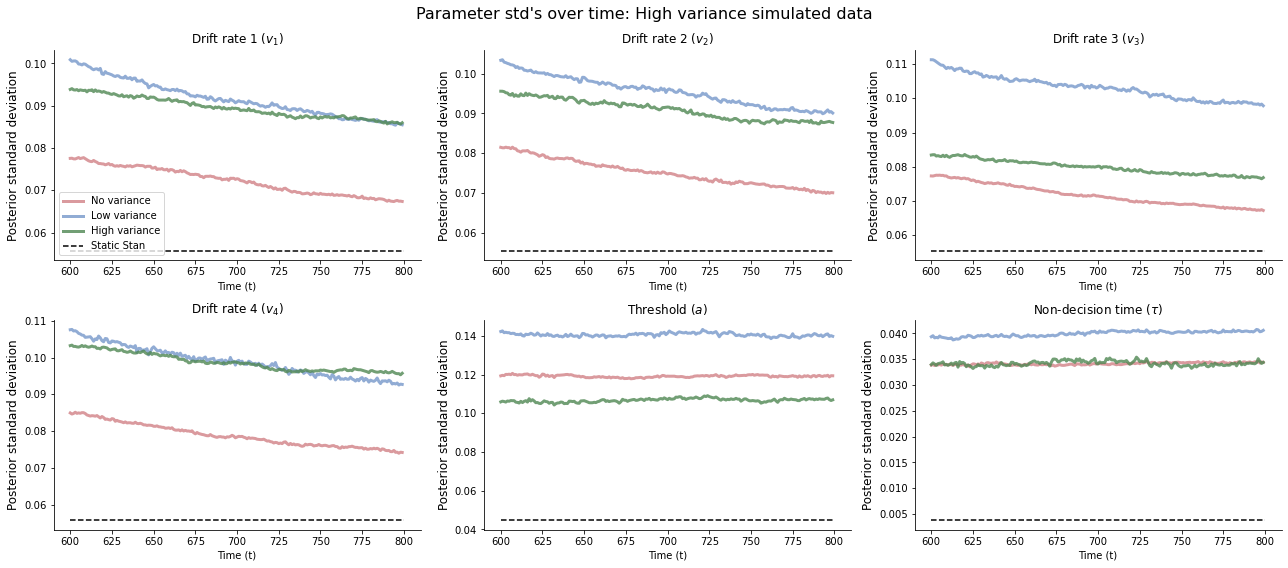

In [167]:
plot_post_sd(stan_post_samples, sim_data, 200, 2)